# Data preparation

In [19]:
import pandas as pd
import numpy as np

In [20]:
# Loading series names
with open("/content/series_names_most_important.txt", encoding="utf8") as file:
  series_names = [line.strip() for line in file]

len(series_names), series_names[:5]

(50,
 ['arca',
  'british touring car championship',
  'btcc',
  'bathurst',
  'british gt'])

In [21]:
# Loading messages
df_messages = pd.read_csv("/content/all_messages.csv", sep=";")
df_messages.head(2)

,Unnamed: 0,id,channel_id,user_id,message_time,message_content,prediction
0,0,1,0,0,0,where can i watch the gp,0.0
1,1,2,0,0,0,can someone send link for the race,0.0


In [22]:
# Drop useless columns
df_messages = df_messages.drop(labels=["Unnamed: 0", "id", "channel_id",
                                       "user_id", "message_time"],
                               axis=1)
df_messages.head(2)

,message_content,prediction
0,where can i watch the gp,0.0
1,can someone send link for the race,0.0


In [23]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   message_content  8495 non-null   object 
 1   prediction       8795 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.5+ KB


In [24]:
df_messages['category'] = pd.cut(x=df_messages['prediction'], 
                                 bins=[0, 0.2, 1],
                                 include_lowest=True)
df_messages['category_id'] = pd.factorize(values=df_messages['category'], 
                                          sort=True)[0]

df_messages.head(2)

,message_content,prediction,category,category_id
0,where can i watch the gp,0.0,"(-0.001, 0.2]",0
1,can someone send link for the race,0.0,"(-0.001, 0.2]",0


In [25]:
# Check number of samples in each category
df_messages["category_id"].value_counts()

1    8553
0     242
Name: category_id, dtype: int64

In [26]:
df_messages = df_messages.drop(labels=["prediction", "category"], axis=1)
df_messages.head(2)

,message_content,category_id
0,where can i watch the gp,0
1,can someone send link for the race,0


In [27]:
df_messages["message_content"] = df_messages["message_content"].apply(
    lambda msg: str(msg).lower())
df_messages.head(2)

,message_content,category_id
0,where can i watch the gp,0
1,can someone send link for the race,0


In [28]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   message_content  8795 non-null   object
 1   category_id      8795 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 137.5+ KB


## Create extra samples with other series names

We noticed that most people are asking for a F1 & F2 streams. However, there are more interesting series. I decided to replace all the words f1 & f2 with a name of other series.

In [29]:
stream_samples = df_messages[df_messages["category_id"] == 0]["message_content"]\
  .to_list()
non_stream_samples = df_messages[df_messages["category_id"] == 1]\
  ["message_content"].to_list()

In [30]:
def create_extra_samples(list_of_messages: list,
                         category_id: int):
  """
  Replaces f1 & f2 words with other series names.

  Parameters
  ----------
  list_of_messages (list): list of messages you want to extend.
  category_id (int): id of the category.
  """
  extended_list_of_messages = []

  for msg in list_of_messages:
    if "f1" in msg:
      for series in series_names:
            extended_list_of_messages.append(msg.replace('f1', series))

    elif "f2" in msg:
      for series in series_names:
            extended_list_of_messages.append(msg.replace('f2', series))

    else:
      extended_list_of_messages.append(msg)

  return pd.DataFrame(data={"message_content": extended_list_of_messages,
                            "category_id": category_id})

In [31]:
stream_samples = create_extra_samples(stream_samples, 0)
non_stream_samples = create_extra_samples(non_stream_samples, 1)

extended_df_messages = pd.concat([stream_samples, non_stream_samples])
extended_df_messages = extended_df_messages.drop_duplicates(subset=['message_content'])
extended_df_messages.head(2)

,message_content,category_id
0,where can i watch the gp,0
1,can someone send link for the race,0


In [32]:
extended_df_messages["category_id"].value_counts()

1    16422
0     1763
Name: category_id, dtype: int64

# Import required libraries and modules

In [33]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2022-07-01 08:40:09--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-01 08:40:09 (64.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [34]:
def prepare_class_weights(dataframe):
  """
  Calculates class weights for unbalanced datasets.
  """
  total_number_of_samples = dataframe.shape[0]
  stream_requests = dataframe["category_id"].value_counts()[0]
  non_stream_requests = dataframe["category_id"].value_counts()[1]

  weight_for_stream_requests = ((1 / stream_requests) 
                              * (total_number_of_samples / 2.))
  weight_for_non_stream_requests = ((1 / non_stream_requests) 
                                    * (total_number_of_samples / 2.))

  class_weight = {0: weight_for_stream_requests, 
                  1: weight_for_non_stream_requests}

  return class_weight

# Model 1 - baseline model

## Setting class weights

Since there is a huge imbalance between number of messages with and without stream requests, I decided to implement `class weights` concept to my model -> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Split data into training and validation datasets

In [35]:
# Calculate class weights for model 1
model_1_class_weights = prepare_class_weights(df_messages)
model_1_class_weights

{0: 18.171487603305785, 1: 0.5141470828948906}

In [36]:
df_messages_shuffled = df_messages.sample(frac=1)

train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    df_messages_shuffled["message_content"].to_numpy(),
    df_messages_shuffled["category_id"].to_numpy(),
    test_size=0.1,
    random_state=42)

# Check shapes of train and validation datasets
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((7915,), (880,), (7915,), (880,))

## Prepare TextVectorization and Embedding layers

In [37]:
max_vocab_length = 4000 # max number of words to have in my vocabulary
max_length = 12 # max length my sentences will be (e.g. how many words from 
                # a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

# Fit the text vectorizer to the train data
text_vectorizer.adapt(train_sentences)

In [38]:
embedding = layers.Embedding(
    input_dim=max_vocab_length, # set input shape 
    output_dim=64, # output shape - each token is described with 64 values
    input_length=max_length) # how long is each input (12)

### Display most popular and the rarest words 

In [39]:
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in training data
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

# [UNK] - unknown
top_5_words, bottom_5_words

(['', '[UNK]', 'the', 'i', 'a'], ['knocked', 'knives', 'kmh', 'klimi', 'kk'])

In [40]:
# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

## Build a first model

In [41]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1")

In [42]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 12)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 12, 64)            256000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 289,089
Trainable params: 289,089
Non-trainable params: 0
_____________________________________________________

In [43]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
# Fit the model
model_1_history = model_1.fit(train_sentences, train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  dir_name=SAVE_DIR,
                                  experiment_name="model_1")],
                              class_weight=model_1_class_weights)

Saving TensorBoard log files to: model_logs/model_1/20220701-084221
Epoch 1/5
248/248 [==============================] - 12s 20ms/step - loss: 0.2337 - accuracy: 0.9818 - val_loss: 0.0411 - val_accuracy: 0.9898
Epoch 2/5
248/248 [==============================] - 4s 17ms/step - loss: 0.0453 - accuracy: 0.9939 - val_loss: 0.0354 - val_accuracy: 0.9898
Epoch 3/5
248/248 [==============================] - 4s 17ms/step - loss: 0.0076 - accuracy: 0.9973 - val_loss: 0.0264 - val_accuracy: 0.9932
Epoch 4/5
248/248 [==============================] - 4s 17ms/step - loss: 0.0210 - accuracy: 0.9965 - val_loss: 0.0707 - val_accuracy: 0.9852
Epoch 5/5
248/248 [==============================] - 4s 17ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.0486 - val_accuracy: 0.9909


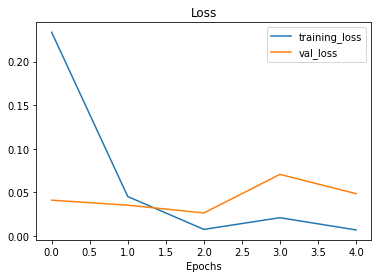

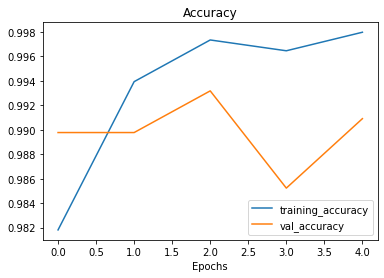

In [45]:
plot_loss_curves(model_1_history)

In [46]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:5]

array([[0.9996818 ],
       [0.999756  ],
       [0.9997728 ],
       [0.99964225],
       [0.99966735]], dtype=float32)

In [47]:
# Convert model 1 pred probs to labels
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [51]:
# Display wrong predictions
compare_results_with_true_labels = pd.DataFrame(
    data={"val_sentences": val_sentences,
          "val_labels": val_labels,
          "model_1_preds": model_1_preds})

compare_results_with_true_labels["model_1_preds"] =\
      compare_results_with_true_labels["model_1_preds"].apply(lambda x: int(x))

compare_results_with_true_labels[compare_results_with_true_labels["val_labels"]\
                                 != compare_results_with_true_labels["model_1_preds"]]


,val_sentences,val_labels,model_1_preds
34,how does webtorrent work btw?,1,0
143,||stream||,1,0
286,link?,1,0
317,is it ok to link streams here btw?,1,0
321,so there will be a link here to watch f1 testi...,0,1
363,lmk if ya find a chili bowl stream,0,1
479,no streams for f1 available?,0,1
869,gimme stream,1,0


# Model 2: extended with additional series

## Split data into training and validation datasets

In [54]:
extended_df_shuffled = extended_df_messages.sample(frac=1)

train_sentences, val_sentences, train_labels, val_labels = train_test_split(extended_df_shuffled["message_content"].to_numpy(),
                                                                            extended_df_shuffled["category_id"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data
                                                                            random_state=42)

# Check shapes of train and validation datasets
train_sentences.shape, val_sentences.shape, train_labels.shape, val_labels.shape

((16366,), (1819,), (16366,), (1819,))

## Prepare TextVectorization and Embedding layers

In [55]:
max_vocab_length = 4500
max_length = 15

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

# Fit the text vectorizer to the train data
text_vectorizer.adapt(train_sentences)

In [56]:
embedding = layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=64,
    input_length=max_length)

### Display most popular and the rarest words 

In [57]:
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in training data
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

# [UNK] - unknown
top_5_words, bottom_5_words

(['', '[UNK]', 'the', 'i', 'is'],
 ['mecca', 'mec', 'measures', 'measurements', 'meanwhi'])

## Model 2

In [69]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")

model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 64)            288000    
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 321,089
Trainable params: 321,089
Non-trainable params: 0
_____________________________________________________

In [70]:
model_2.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [71]:
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220701-085830
Epoch 1/5
512/512 [==============================] - 18s 29ms/step - loss: 0.0282 - accuracy: 0.9916 - val_loss: 0.0095 - val_accuracy: 0.9984
Epoch 2/5
512/512 [==============================] - 11s 21ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0101 - val_accuracy: 0.9984
Epoch 3/5
512/512 [==============================] - 10s 20ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0100 - val_accuracy: 0.9984
Epoch 4/5
512/512 [==============================] - 11s 21ms/step - loss: 0.0014 - accuracy: 0.9996 - val_loss: 0.0100 - val_accuracy: 0.9984
Epoch 5/5
512/512 [==============================] - 10s 20ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0071 - val_accuracy: 0.9978


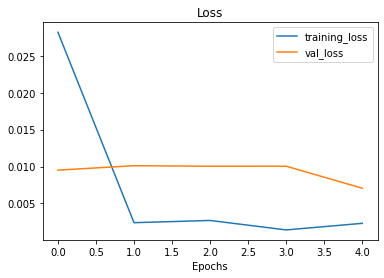

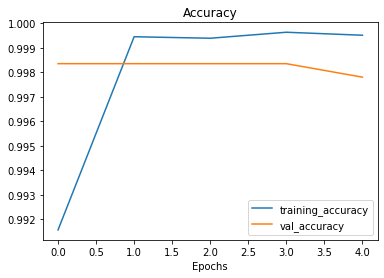

In [72]:
plot_loss_curves(model_2_history)

In [73]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:5]

array([[0.9999838 ],
       [0.00359869],
       [0.9999865 ],
       [0.99998367],
       [0.99998724]], dtype=float32)

In [74]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 1., 0., 1., 1., 1.], dtype=float32)>

In [81]:
# Display wrong predictions
compare_results_with_true_labels = pd.DataFrame(
    data={"val_sentences": val_sentences,
          "val_labels": val_labels,
          "model_2_preds": model_2_preds})

compare_results_with_true_labels["model_2_preds"] =\
      compare_results_with_true_labels["model_2_preds"].apply(lambda x: int(x))

compare_results_with_true_labels[compare_results_with_true_labels["val_labels"] !=\
                                 compare_results_with_true_labels["model_2_preds"]]

,val_sentences,val_labels,model_2_preds
143,stream anyone kurwa jego mać?,1,0
1253,nascar stream?,0,1
1374,anyone got the ol snowball derby,0,1
1512,"hey, can someone help me with this...? whats t...",0,1
